In [1]:
%matplotlib notebook
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import matplotlib
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from rasterio import features
from Map_Tools import map_elements as me
# from matplotlib.patches import BoxStyle
import matplotlib.patheffects as pe
import pandas as pd

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1 #set the value globally

import geopandas as gpd
from matplotlib import colors
# import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.gridspec import GridSpec

G_Drive = 'C:\\Users\\User\\Google Drive\\'

Save_Plots=G_Drive+'PhD_Thesis\\Chapter3_Figs/'


Projected_Image = 'temp/FI_Projected.tif'


FI_Poly= gpd.read_file(G_Drive+'SiteInfo\\FishIsland_Poly.shp')
BL_Poly= gpd.read_file(G_Drive+'SiteInfo\\BigLake.shp')

pt=gpd.read_file(G_Drive+'FishIsland_Outputs\Classification/Points.shp')
# print(pt)
POI = pt.to_crs(FI_Poly.crs)
POI.crs


<Projected CRS: EPSG:32608>
Name: WGS 84 / UTM zone 8N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 138°W and 132°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territiories (NWT); Yukon. United States (USA) - Alaska (AK).
- bounds: (-138.0, 0.0, -132.0, 84.0)
Coordinate Operation:
- name: UTM zone 8N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<IPython.core.display.Javascript object>


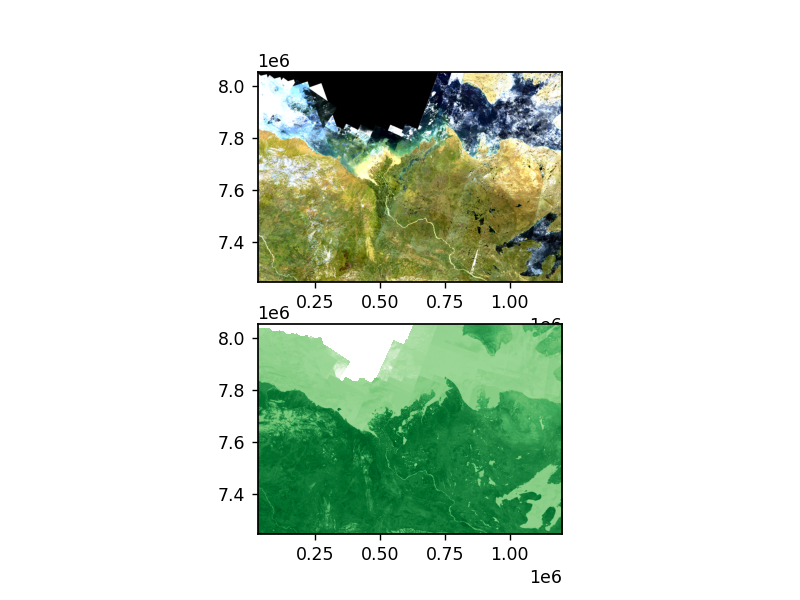

In [2]:
def pct_clip(array,pct=[10,90]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip
FC = 1

File = 'False_Color_Landsat.tif'

with rio.open(G_Drive+'earthengine/'+File) as src:
    with rio.open(
            'temp/False_Color_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
#         print(src.read(5))
        V = pct_clip(src.read(4+FC))
        dst.write(V,1)
        V = pct_clip(src.read(3+FC))
        dst.write(V,2)
        V = pct_clip(src.read(2+FC))
        dst.write(V,3)
    FC = 0
    with rio.open(
            'temp/True_Color_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
#         print(src.read(5))
        V = pct_clip(src.read(4+FC))
        dst.write(V,1)
        V = pct_clip(src.read(3+FC))
        dst.write(V,2)
        V = pct_clip(src.read(2+FC))
        dst.write(V,3)
    

# # with rio.open(G_Drive+'earthengine/False_Color_Landsat.tif') as src:
#     with rio.open(
#             'temp/NDVI_Temp.tif', 'w+',
#             driver='GTiff',
#             dtype= rio.float32,
#             count=1,
#             crs = src.crs,
#             width=src.width,
#             height=src.height,
#             transform=src.transform,
#         ) as dst:
#         B5 = pct_clip(src.read(5),pct=[1,99])
#         B4 = pct_clip(src.read(4),pct=[1,99])
#         NDVI = (B5-B4)/(B5+B4)
#         print(B5)
#         dst.write(NDVI,1)
    
fig,ax=plt.subplots(2)
with rio.open("temp/True_Color_Temp.tif") as src2:
#     print(src2.read())
    show(src2.read(),transform=src2.transform,ax=ax[0])
    
    
with rio.open(G_Drive+"earthengine/Delta_Greenest.tif") as src2:
    FC = src2.read()
    show(FC,ax=ax[1],transform=src2.transform,cmap='Greens')

# BLDP Mask

In [3]:
Water_Thresh = 0.25

with rio.open(Projected_Image) as src:
    Im = src.read()
    params = src.profile
    Transform = src.transform
    NDVI = Im.max(axis=0)
    Mask = NDVI.copy()
    Mask[Mask<Water_Thresh]=0
    Mask[Mask>=Water_Thresh]=1
    
    Mask2= Mask.copy()
    Mask2[Mask2==0]=np.nan
    print(Im.shape,Mask2.shape)
    
BLDP = BL_Poly.dissolve()

BLDP['Id']+=1
import pprint

shapes = ((geom,value) for geom,value in zip (BLDP['geometry'],BLDP['Id']))
# print(Polys.groupby('Code').sum().area)
with rio.open('temp/BLDP.tif','w+',**params) as out:
    out_arr=out.read(1)
    Image=features.rasterize(shapes=shapes,fill=-9999,out=out_arr,transform=Transform)
    Image = (Image+1) * Mask
    out.write(Image,1)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(Image, mask=None, transform=src.transform)))

Filter = 1e5
    
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)
BLDP_Inv = Temp.loc[Temp['raster_val']>0].copy()#
BLDP_Inv.loc[((BLDP_Inv['raster_val']>0.5)&(BLDP_Inv.area<Filter)),'raster_val']=np.nan
BLDP_Inv.loc[((BLDP_Inv['raster_val']>1)),'raster_val']=np.nan
Bad = BLDP_Inv[BLDP_Inv.geometry.is_valid==False].buffer(0)
BLDP_Inv.loc[BLDP_Inv.geometry.is_valid==False,'geometry']=Bad.geometry
BLDP_Inv = BLDP_Inv.dropna().dissolve(by='raster_val')


BLDP = Temp.loc[Temp['raster_val']>1].copy()#
BLDP.loc[((BLDP['raster_val']>1)&(BLDP.area<Filter)),'raster_val']=np.nan
# BLDP_Inv.loc[((BLDP_Inv['raster_val']>1)),'raster_val']=np.nan
Bad = BLDP[BLDP.geometry.is_valid==False].buffer(0)
BLDP.loc[BLDP.geometry.is_valid==False,'geometry']=Bad.geometry
BLDP = BLDP.dropna().dissolve(by='raster_val')


# fig,ax=plt.subplots()
# BLP = params.copy()
# BLP['count']=1
# with rio.open('temp/BLDP_Mask.tif','w+',**BLP) as out:
#     out_arr=out.read(1)
#     shapes = ((geom,value) for geom,value in zip (BLDP['geometry'],[1]))
#     Image=features.rasterize(shapes=shapes,fill=-9999,out=out_arr,transform=out.transform)
#     out.write(Image,1)
#     show(Image)

(8, 3483, 3325) (3483, 3325)


# Inset Mask

In [4]:
rivers = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/hydro_rivers_l.shp')
rivers = rivers.to_crs(FI_Poly.crs)
rivers = rivers.buffer(1e2)

land = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/hydro_land_p.shp')
land = land.to_crs(FI_Poly.crs)


<IPython.core.display.Javascript object>


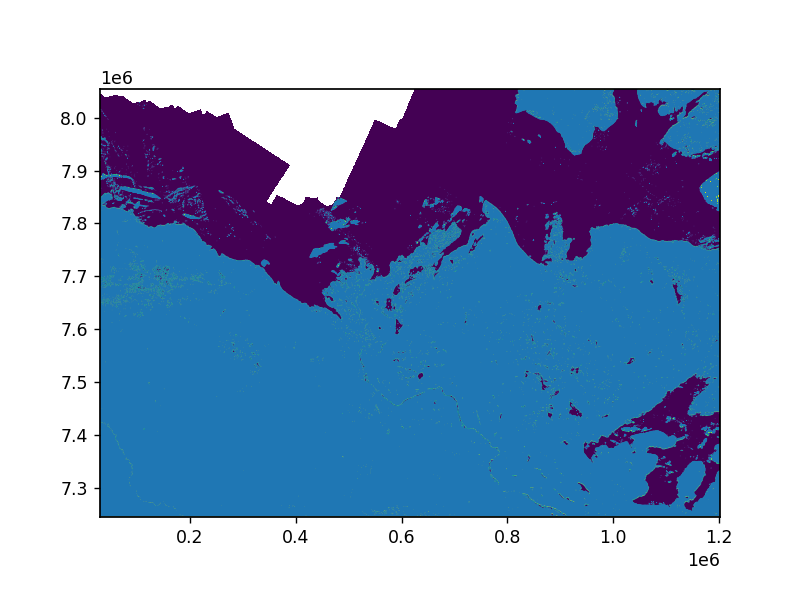

<AxesSubplot:>

In [5]:
Water_Thresh = 0.15

Feat=['lake','land','isle','ocean']
code=[1,1,1,np.nan]
for f,c in zip(Feat,code):
    land.loc[land['FEAT_E']==f,'Code']=c

shapes = ((geom,value) for geom,value in zip (land['geometry'],land['Code']))

# fig,ax=plt.subplots()
with rio.open(G_Drive+"earthengine/Delta_Greenest.tif") as src:
    G = src.read()
    Ins_params = src.profile
    Ins_Transform = src.transform
    NDVI = G.max(axis=0)
    Mask = np.round(NDVI.copy(),2)
#     Mask[NDVI>=Water_Thresh]=1
#     Image=features.rasterize(shapes=shapes,fill=-9999,out=out_arr,transform=Ins_Transform)
#     Mask = (Image) * Mask
    Mask[Mask<Water_Thresh]=0
    Mask[Mask>=Water_Thresh]=1
    show(Mask,ax=ax,transform=Ins_Transform)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(Mask, mask=None, transform=Ins_Transform)))
    
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)

Temp['raster_val'].unique()
Land_Ins = Temp.loc[Temp['raster_val']==1].copy()#
# # # Land_Ins.loc[((Land_Ins['raster_val']>0.5)&(Water.area<1e6)),'raster_val']=np.nan
Bad = Land_Ins[Land_Ins.geometry.is_valid==False].buffer(0)
Land_Ins.loc[Land_Ins.geometry.is_valid==False,'geometry']=Bad.geometry
Land_Ins=Land_Ins.dissolve()

# Land_Ins = Land_Ins.dropna()
# Land_Ins.plot(ax=ax)

# Landmarks

In [22]:


Lat = [68+ 21/60+ 39/3600,
       69+ 26/60+ 7/3600,
      68.215584,67.451107, 
      ]
Lon = [-133 -43/60 -47/3600,
       -132 -59/60 -5/3600,
       -135.004048,-133.753267,
      ]

Lmk = pd.DataFrame(data = {'Name':['Inuvik','Tuktoyaktuk','Aklavik',
                                  'Tsiigehtchic'],
                         'Lat':Lat,
                         'Lon':Lon})

Lmk = gpd.GeoDataFrame(
                    Lmk,
                    geometry=gpd.points_from_xy(Lmk.Lon, Lmk.Lat),
                    crs='WGS1984'
                        )
Lmk = Lmk.to_crs(POI.crs)

Lmk = Lmk.loc[Lmk['Name']=='Inuvik']

print(Lmk)
# print()
# print()
# print(KP.distance(Temp))



     Name        Lat         Lon                        geometry
0  Inuvik  68.360833 -133.729722  POINT (552272.559 7583633.533)


# Final Map

In [33]:
Lat = [69.21889,68.68472]
Lon = [-134.2911,-134.1458]
# 69.36917 	 	

import pandas as pd
CALM = pd.DataFrame(data = {'Name':['Lousey Pt.','Reindeer Stn.'],
                         'Lat':Lat,
                         'Lon':Lon})
CALM = gpd.GeoDataFrame(
                    CALM,
                    geometry=gpd.points_from_xy(CALM.Lon, CALM.Lat),
                    crs='WGS1984'
                        )


CALM = CALM.to_crs(POI.crs)


Temp = POI.loc[POI['Label']=='EC']#.crs
Temp =Temp.append(Temp).reset_index()
Temp =Temp.append(Temp).reset_index()

print(CALM)
print()
print(CALM.distance(Temp))

            Name       Lat       Lon                        geometry
0     Lousey Pt.  69.21889 -134.2911  POINT (528069.238 7678932.027)
1  Reindeer Stn.  68.68472 -134.1458  POINT (534650.899 7619448.292)

0    28888.013660
1    82103.466749
2             NaN
3             NaN
dtype: float64


C:\Users\User\.conda\envs\geo-env\lib\site-packages\geopandas\base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [34]:
Lat = [69+ 25/60+23/3600,69+23/60+21/3600]
Lon = [-135- 55/3600,-134-58/60-8/3600]

KP = pd.DataFrame(data = {'Name':['Kuluarpak Channel','Big Lake'],
                         'Lat':Lat,
                         'Lon':Lon})

KP = gpd.GeoDataFrame(
                    KP,
                    geometry=gpd.points_from_xy(KP.Lon, KP.Lat),
                    crs='WGS1984'
                        )
KP = KP.to_crs(POI.crs)

print(KP)
print()
print()
print(KP.distance(Temp))



                Name        Lat         Lon                        geometry
0  Kuluarpak Channel  69.423056 -135.015278  POINT (499400.737 7701535.986)
1           Big Lake  69.389167 -134.968889  POINT (501222.238 7697757.278)


0    7732.307762
1    3931.152640
2            NaN
3            NaN
dtype: float64


C:\Users\User\.conda\envs\geo-env\lib\site-packages\geopandas\base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


<IPython.core.display.Javascript object>


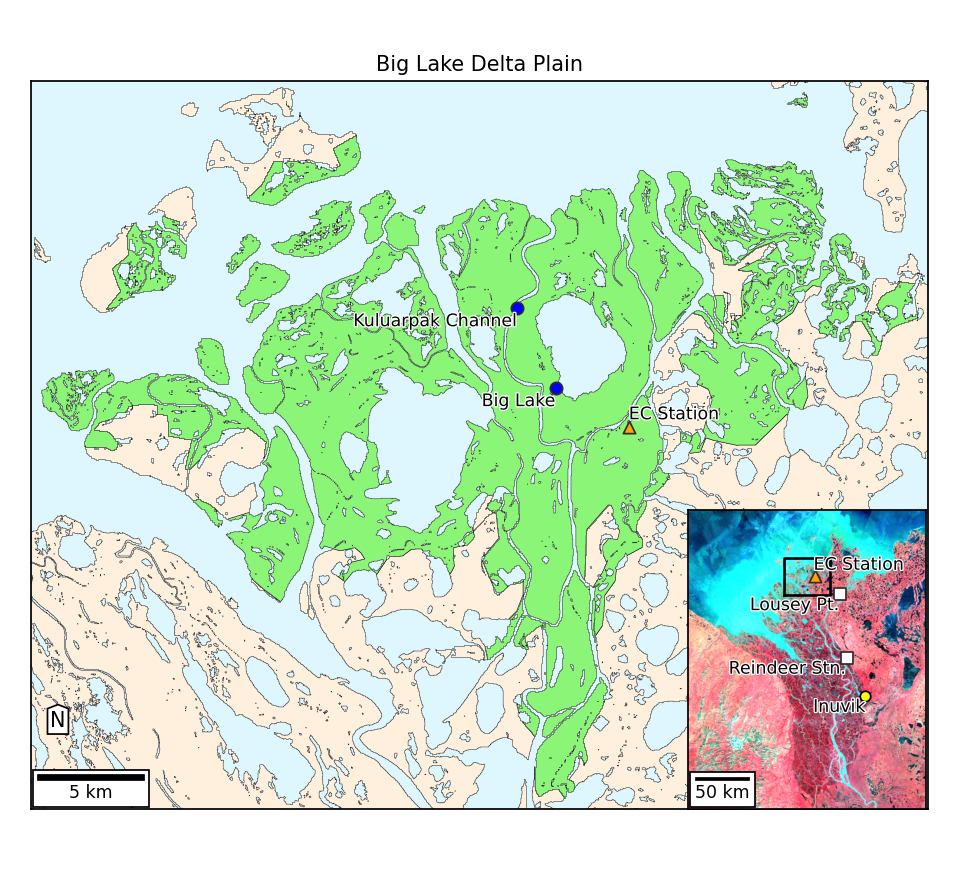

In [65]:
edgecolor='#2e2e2e'
linewidth=0.3

fig,ax = plt.subplots(figsize=(6.2,5.7))
CL = ['#d9fffe','#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
cmap = colors.ListedColormap(CL)
bounds = [-1,0.3,0.4,0.5,0.6,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

BLDP_NDVI = (Im.max(axis=0)*Mask2).round(2)


buff=5e2
xb = [BLDP.bounds['minx'].values[0]-buff,BLDP.bounds['maxx'].values[0]+buff]
yb = [BLDP.bounds['miny'].values[0]-buff,BLDP.bounds['maxy'].values[0]+buff]
ax.set_xlim(xb)
ax.set_ylim(yb)
# ax.set_ylim()

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Big Lake Delta Plain')

BLDP_Inv.plot(ax=ax,color='#fff0de',edgecolor=edgecolor,linewidth=linewidth)#,hatch="/")
BLDP.plot(ax=ax,color='#8bf578',edgecolor=edgecolor,linewidth=linewidth)#,hatch="/")
ax.set_facecolor('#def7ff')
POI.loc[POI['Label']=='EC'].plot(ax=ax,marker='^',color='orange',edgecolor=edgecolor,markersize=50)

for i,row in POI.loc[POI['Label']=='EC'].iterrows():
    ax.text(row.geometry.x,row.geometry.y+200,"EC Station",
       fontsize=10,ha='left',va='bottom',color='k',
       path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])

KP.plot(ax=ax,marker='o',color='blue',edgecolor=edgecolor,markersize=50)

for i,row in KP.iterrows():
    ax.text(row.geometry.x,row.geometry.y-200,row['Name'],
               fontsize=10,ha='right',va='top',color='k',
               path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])

# Inset Map
axins = ax.inset_axes([0.69, 0.0, 0.35, 0.41])
axins.set_facecolor('#def7ff')

with rio.open("temp/False_Color_Temp.tif") as src2:
    FC = src2.read()
    FC = FC#*Mask
    show(FC,ax=axins,
         transform=src2.transform)


x_scale=9e4
y_scale2=4.5e4
y_scale1=2e5

xbins = [xb[0]-x_scale,xb[1]+x_scale]
ybins = [yb[0]-y_scale1,yb[1]+y_scale2]
axins.set_xlim(xbins)
axins.set_ylim(ybins)

CALM.plot(ax=axins,marker='s',color='white',edgecolor=edgecolor,markersize=50)
POI.loc[POI['Label']=='EC'].plot(ax=axins,marker='^',color='orange',edgecolor=edgecolor,markersize=50)

for i,row in POI.loc[POI['Label']=='EC'].iterrows():
    axins.text(row.geometry.x-1000,row.geometry.y+2000,"EC Station",
       fontsize=10,ha='left',va='bottom',color='k',
       path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])

for i,row in CALM.iterrows():
    axins.text(row.geometry.x,row.geometry.y-2000,row['Name'],
       fontsize=10,ha='right',va='top',color='k',#rotation=-10,
       path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])

Lmk.plot(ax=axins,edgecolor='k',color='yellow')

for i,row in Lmk.iterrows():
    if row['Name']=='Inuvik':
        axins.text(row.geometry.x,row.geometry.y-2000,row['Name'],
           fontsize=10,ha='right',va='top',color='k',#rotation=-10,
           path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])


me.scalebar(axins,distance=5e4,label='50 km',pos='lower left')

XB = [xb[0],xb[0],xb[1],xb[1],xb[0]]
YB = [yb[0],yb[1],yb[1],yb[0],yb[0]]


axins.plot(XB,YB,color='k',linewidth=1.5)
# axins.plot(XB,YB,color='r',linewidth=1)
axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)


me.scalebar(ax,distance=5e3,label='5 km')

me.North_Arrow(ax,x=0.03,y=0.12)
# ax.legend()


plt.tight_layout()
plt.savefig(Save_Plots+'Greenest_Pixel.png',dpi=600)


In [8]:
xb = xbins
yb = ybins

from shapely.geometry import Polygon

XB = [xb[0],xb[0],xb[1],xb[1],xb[0]]
YB = [yb[0],yb[1],yb[1],yb[0],yb[0]]

# BB = pd.DataFrame(data = {'id':np.arange(0,5),
#                          'X':XB,
#                          'Y':YB})
# BB.crs = FI_Poly.crs
# # print(BB)
# BB

polygon_geom = Polygon(zip(XB, YB))
BB = gpd.GeoDataFrame(index=[0], crs=FI_Poly.crs, geometry=[polygon_geom])
BB = BB.to_crs('WGS1984')
BB.to_file('temp/BoundingBox.shp')
print(BB)

                                            geometry
0  POLYGON ((-138.51366 66.92962, -139.06317 70.1...


In [14]:
# # Terr4m_relief
# fig,ax=plt.subplots()
# with rio.open(G_Drive+"NorthernCan/Terr4m_relief.tif") as src2:
#     print(src2.profile)
#     DEM = src2.read()
#     show(DEM)
# print(DEM.max())

<IPython.core.display.Javascript object>


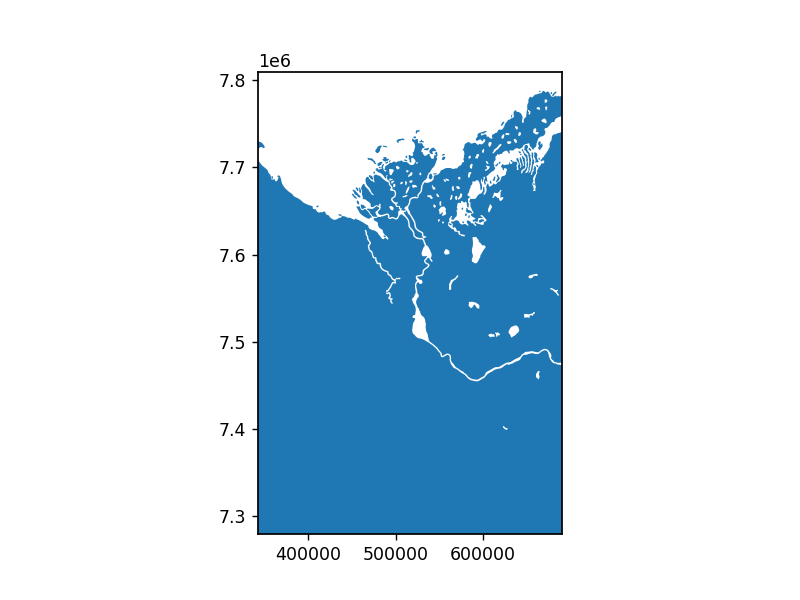

<AxesSubplot:>

In [67]:
# rivers = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/hydro_rivers_l.shp')
# rivers = rivers.to_crs(FI_Poly.crs)
# rivers = rivers.buffer(1e2)



# land.FEAT_E.unique()

<IPython.core.display.Javascript object>


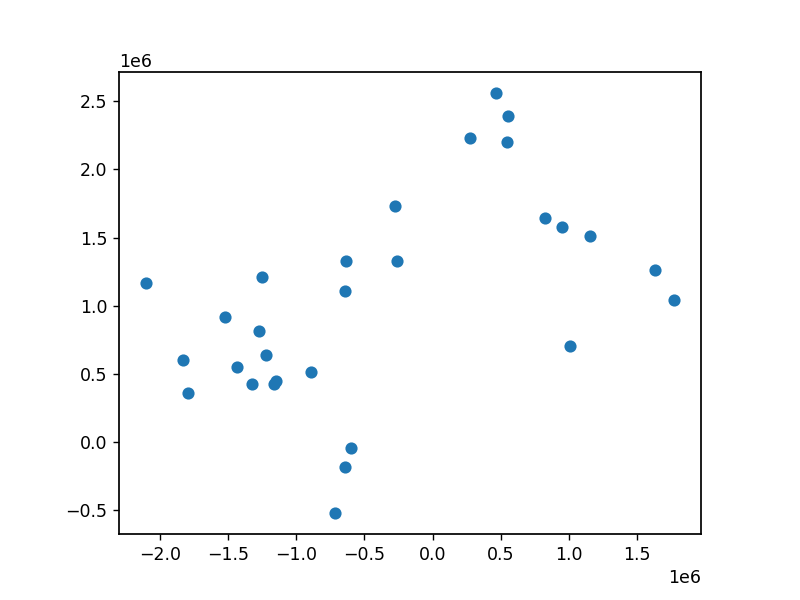

<AxesSubplot:>

In [66]:
# el = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/elevation_pt.shp')
el.plot()